#First Project - COMP 551

[Link](https://mycourses2.mcgill.ca/content/enforced/495331-15812.202101/551P1W21.pdf?_&d2lSessionVal=DARoDapct3pTW4gYIBVudaEKF) to Assignment instructions.

[Link](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/KNN.ipynb) to example of nearest neighbors implementation.

[Link](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/DecisionTree.ipynb) to example of decision tree implementation.



# Abstract
The objective of this projeect is to determine which classification method among K-Nearest Neighbors (KNN) and Decision Trees (DT) is most accurate. We made predictions useing two benchmark datasets, one on breast cancer diagnosis and the other concerning hepatitis prognosis. First we discuss the cleaning of the datasets. Then, after implementing and optimizing both methods, we select the most highly predictive features, best cost functions, distance functions and hyperparameters. Ultimately, we determine that KNN was better at predicting malignant cases of breast cancer, as well as predicting lethal cases of hepatitis, than DT. Additionally, we discuss the effects of imbalanced data on these methods.








#HOW TO RUN

To run the code, first run the "import packages" code. Additionally, run the "KNN class" and "Decision Tree class", as they contain the class definitions. 

Note that you must run the "convert numpy array" before training the models.

# IMPORT PACKAGES

Import packages


In [ ]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import hashlib as hl

import statistics
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.core.debugger import set_trace         #for debugging 

np.random.seed(123)

Setup Content

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


**This section is to upload the data from drive**


If you want to see how to upload on drive  look [here](https://colab.research.google.com/drive/18QoifMK96VraKlQgOz3_7iAXAeURoR9u#scrollTo=2Wqkv-w0_Eju&line=2&uniqifier=1).


#KNN Class

In [ ]:
#define the metric we will use to measure similarity
#if the input shapes are [1,N1,F] and [N2,1,F] then output shape is [N2,N1]
#as numpy supports broadcasting with arithmetic operations
#for more on numpy broadcasting refer to: https://numpy.org/doc/stable/user/basics.broadcasting.html  

euclidian = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
hamming = lambda x1, x2: 0 if x1 != x2 else 1
# hamming_distance
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)
class KNN:

    def __init__(self, K=1, dist_fn= euclidian):
        self.dist_fn = dist_fn
        self.K = K
        return
    
    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y.astype(int) # class should always be int (0 or 1)
        self.C = int(np.max(y) + 1)
        return self
    
    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
        #calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
        
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        #ith-row of knns stores the indices of k closest training samples to the ith-test sample 
        knns = np.zeros((num_test, self.K), dtype=int)
        #ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, int(self.C)))

        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
        y_prob /= np.sum(y_prob, axis=-1, keepdims=True)
        
        #simply divide by K to get a probability distribution
        y_prob /= self.K
        return y_prob, knns

# Decision Tree Class



In [ ]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node 
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent 
            self.num_classes = parent.num_classes           #copies the num classes from the parent 
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels.astype(int)         #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built


def greedy_test(node, cost_fn):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue
            #compute the left and right cost based on the current split                                                         
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value



#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    labels = labels.astype(int)
    counts = np.bincount(labels) 
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    labels = labels.astype(int)
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    labels = labels.astype(int)
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2


class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_entropy, min_leaf_instances=1, min_cost = 0.001):
        self.max_depth = max_depth      #maximum dept for termination 
        self.root = None                #stores the root of the decision tree 
        self.cost_fn = cost_fn          #stores the cost function of the decision tree 
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        self.min_cost = min_cost #############################
        
    def fit(self, data, labels):
        pass                            #pass in python 3 means nothing happens and the method here is empty
    
    def predict(self, data_test):
        pass
    
    
    
def fit(self, data, labels):
    self.data = data
    self.labels = labels.astype(int)
    if self.num_classes is None:
        self.num_classes = int(np.max(labels) + 1)
    #below are initialization of the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    #to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self

def _fit_tree(self, node):
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances :
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return

    if cost <= self.min_cost: ####################################
      return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}') ##########################################
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    #assign the left and right child to present child
    node.left = left
    node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree



def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root
        #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n,:] = node.class_prob
    return class_probs

DecisionTree.predict = predict

# DATASET 1: Breast Cancer

##Task 1: Acquire, preprocess, and analyze the data

###Data Cleaning


Get Data

In [13]:

#unhash the following snippet if you want to work straight from the csv file on google drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

df1 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Assignment1/breast_cancer_wisconsin.csv")

Mounted at /content/gdrive



Removing rows with missing values

In [14]:
#df1 = pd.read_csv("Assignment1/breast_cancer_wisconsin.csv")  # df1 represents the dataframe for the breast_cancer_wisconsin csv file
df1.head(5)                                       # Observe first 5 rows
df1.isnull().any()                                # Check if there is any missing values in each column 
df1.dtypes

print(df1.shape[0]," rows in df1\n")

df1 = df1.replace('?', np.nan)
df1 = df1.dropna() 

print(df1.shape[0]," rows left in df1\n")         # 16 rows have been removed

df1.reset_index(drop=True, inplace=True) #reset indices (so first instance at index 0, next at index 1...)

df1['Class'] = df1['Class'].replace([2], 0) #benign
df1['Class'] = df1['Class'].replace([4], 1) #malignant
  # replace 2 with 0, 4 with 1 (for decision boundary later)

#delete id column
del df1['id']

df1 = df1.astype(float) # all values are float (instead of string)
df1 = df1.astype({"Class": int})

#print("\n",df1_np)

df1

699  rows in df1

683  rows left in df1



,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...
678,3.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,0
679,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0
680,5.0,10.0,10.0,3.0,7.0,3.0,8.0,10.0,2.0,1
681,4.0,8.0,6.0,4.0,3.0,4.0,10.0,6.0,1.0,1


Outliers

In [ ]:
# removes outliers
df1 = df1[(np.abs(stats.zscore(df1))<3).all(axis=1)]
print(df1.shape[0], ' rows after outlier removal')

632  rows after outlier removal


###Statistics

In [ ]:
df1.describe()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,4.200949,2.787975,2.867089,2.558544,2.837025,3.253165,3.227848,2.609177,1.257911,0.302215
std,2.694562,2.782555,2.709622,2.624955,1.624014,3.500395,2.284513,2.853104,0.766742,0.459582
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,5.000000,4.000000,4.000000,3.000000,3.000000,5.000000,4.000000,3.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,9.000000,10.000000,10.000000,10.000000,6.000000,1.000000


Number of Occurences

In [ ]:
# 0 = benign, 1 = malignant
benign = df1.loc[(df1['Class'] == 0)] 
num_ben = benign.shape[0]
malignant = df1.loc[(df1['Class'] == 1)] 
num_malig = malignant.shape[0]

print('Total # Patients: ', num_ben+num_malig)
print('# Benign: ', num_ben)
print('# Malignant: ', num_malig)
per_malig = (num_malig)/(num_ben+num_malig) * 100
print("% Malignant: " + str(int(per_malig)) + '%')

Total # Patients:  632
# Benign:  441
# Malignant:  191
% Malignant: 30%


####Distribution by Feature

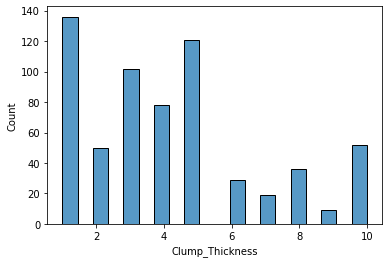

In [ ]:
sns.histplot(df1['Clump_Thickness'], bins = 20, kde = False)

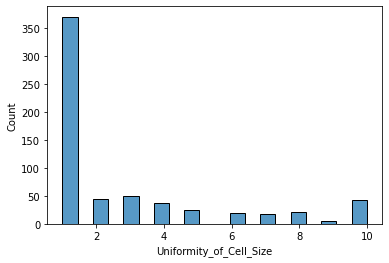

In [ ]:
sns.histplot(df1['Uniformity_of_Cell_Size'], bins = 20, kde = False)

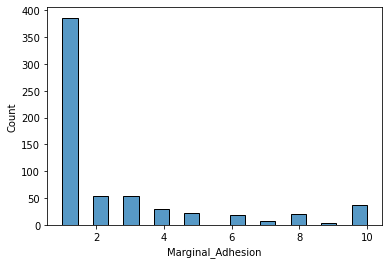

In [ ]:
sns.histplot(df1['Marginal_Adhesion'], bins = 20, kde = False)

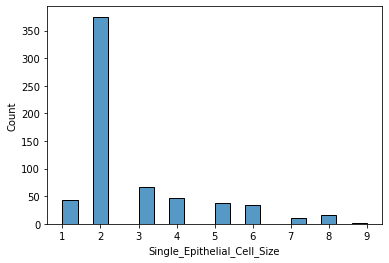

In [ ]:
sns.histplot(df1['Single_Epithelial_Cell_Size'], bins = 20, kde = False)

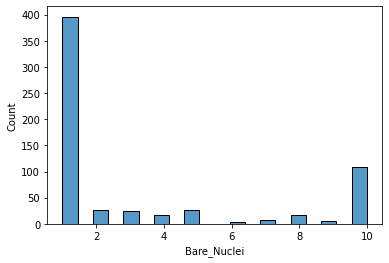

In [ ]:
sns.histplot(df1['Bare_Nuclei'], bins = 20, kde = False)

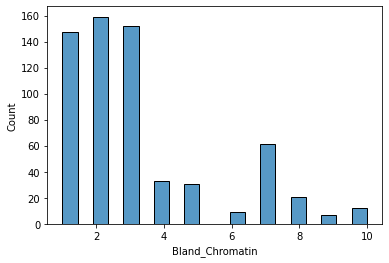

In [ ]:
sns.histplot(df1['Bland_Chromatin'], bins = 20, kde = False)

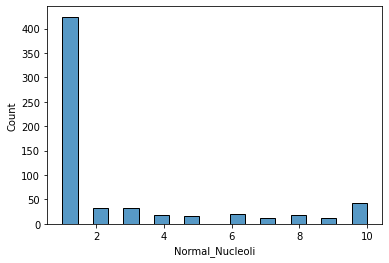

In [ ]:
sns.histplot(df1['Normal_Nucleoli'], bins = 20, kde = False)

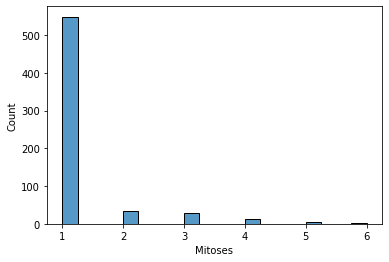

In [ ]:
sns.histplot(df1['Mitoses'], bins = 20, kde = False)

####Positive vs. Negative Distribution by Feature

In [ ]:
pos = df1[df1['Class'] == 1]
neg = df1[df1['Class'] == 0]

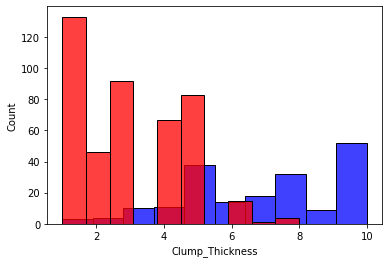

In [ ]:
# by clump thickness
sns.histplot(pos['Clump_Thickness'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['Clump_Thickness'], bins = 10, color = 'r', kde = False)

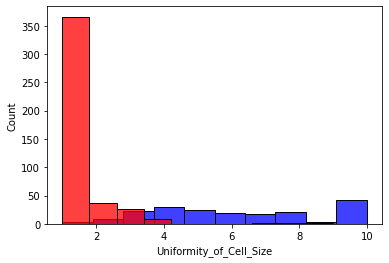

In [ ]:
# by cell size
sns.histplot(pos['Uniformity_of_Cell_Size'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['Uniformity_of_Cell_Size'], bins = 10, color = 'r', kde = False)

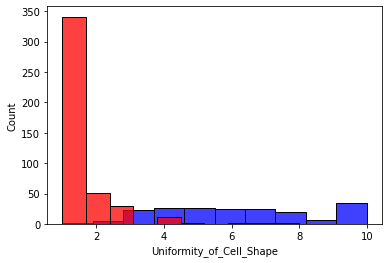

In [ ]:
# by cell shape
sns.histplot(pos['Uniformity_of_Cell_Shape'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['Uniformity_of_Cell_Shape'], bins = 10, color = 'r', kde = False)

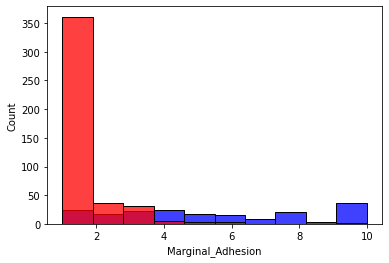

In [ ]:
# by marginal adhesion 
sns.histplot(pos['Marginal_Adhesion'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['Marginal_Adhesion'], bins = 10, color = 'r', kde = False)

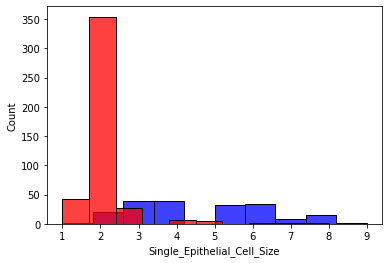

In [ ]:
# by epithelia cell size  
sns.histplot(pos['Single_Epithelial_Cell_Size'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['Single_Epithelial_Cell_Size'], bins = 10, color = 'r', kde = False)

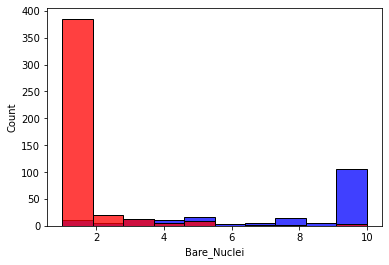

In [ ]:
# by bare nucleoli
sns.histplot(pos['Bare_Nuclei'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['Bare_Nuclei'], bins = 10, color = 'r', kde = False)

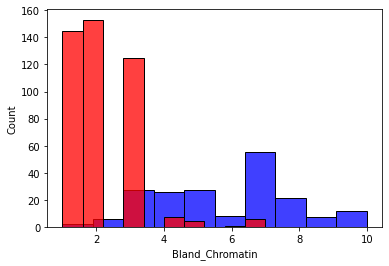

In [ ]:
# by bland chromatin 
sns.histplot(pos['Bland_Chromatin'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['Bland_Chromatin'], bins = 10, color = 'r', kde = False)

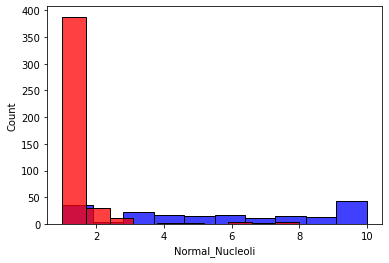

In [ ]:
# by Normal_Nucleoli
sns.histplot(pos['Normal_Nucleoli'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['Normal_Nucleoli'], bins = 10, color = 'r', kde = False)

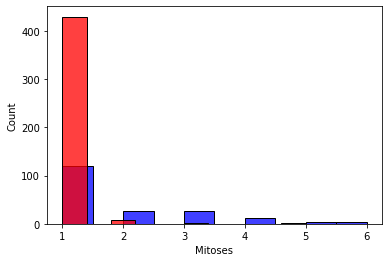

In [ ]:
# by Mitoses
sns.histplot(pos['Mitoses'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['Mitoses'], bins = 10, color = 'r', kde = False)

###Correlation


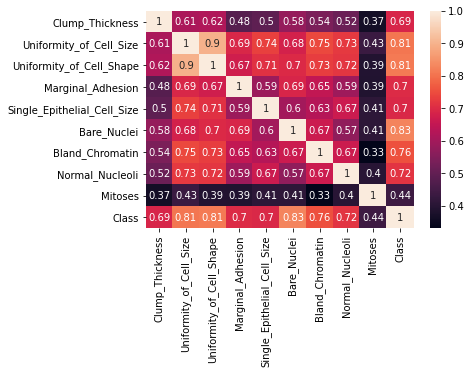

In [ ]:
##### Find if there are any correlation between independent variables pairwise
corr_matrix = df1.corr()
sns.heatmap(corr_matrix,annot = True)
plt.show()

# "Class" (the output) has high correlation with "Uniformity_of_cell_size",
# "Uniformity_of_cell_shape" and "Bare_Nuclei"

##Task 2 & 3: Implement the Models and Run Experiments

###Convert to Numpy Array for ML

In [15]:
df1_np = df1.to_numpy()                           # Convert df1 from pandas dataframe to numpy array

### KNN



####Accuracy

In [16]:
#df1 has one column with mixed types (Bare-Nuclei) -> so cant convert all to int
x = df1_np[:,:-1] # TA said to train on all features initially for part 2 
y = df1_np[:,-1]
print(df1)
num_instances = df1[["Class"]].size
#print(num_instances)
(N, D), C = x.shape, np.max(y)+1
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

inds = np.random.permutation(num_instances)

#train-test split
x_train, y_train = x[inds[:342]], y[inds[:342]]
x_test, y_test = x[inds[342:]], y[inds[342:]]

model = KNN(K=20)

y_prob, knns = model.fit(x_train, y_train).predict(x_test)

#To get hard predictions by choosing the class with the maximum probability
y_pred = np.argmax(y_prob,axis=-1)

accuracy = np.sum(y_pred == y_test)/y_test.shape[0]

print(f'accuracy is {accuracy*100:.1f}.')

     Clump_Thickness  Uniformity_of_Cell_Size  ...  Mitoses  Class
0                5.0                      1.0  ...      1.0      0
1                5.0                      4.0  ...      1.0      0
2                3.0                      1.0  ...      1.0      0
3                6.0                      8.0  ...      1.0      0
4                4.0                      1.0  ...      1.0      0
..               ...                      ...  ...      ...    ...
678              3.0                      1.0  ...      1.0      0
679              2.0                      1.0  ...      1.0      0
680              5.0                     10.0  ...      2.0      1
681              4.0                      8.0  ...      1.0      1
682              4.0                      8.0  ...      1.0      1

[683 rows x 10 columns]
instances (N) 	 683 
 features (D) 	 9 
 classes (C) 	 2.0
accuracy is 95.9.


####Visualization

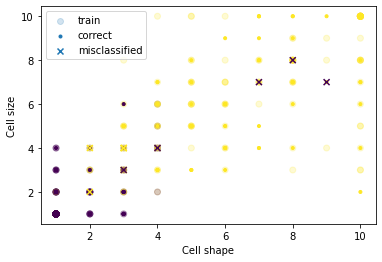

In [17]:
#visualization (plot for 2 features -> most discriminant features = shape and size (indices 1 and 2))
correct = y_test == y_pred
incorrect = np.logical_not(correct)
plt.scatter(x_train[:,1], x_train[:,2], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,1], x_test[correct,2], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,1], x_test[incorrect,2], marker='x', c=y_test[incorrect], label='misclassified')
plt.legend()
plt.ylabel('Cell size')
plt.xlabel('Cell shape')
plt.show()

####Decision Boundary

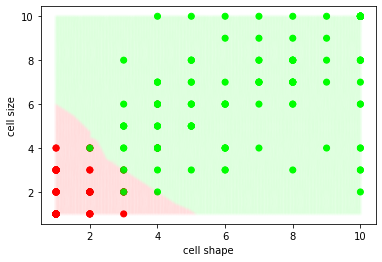

In [18]:
#decision boundary for KNN
#uses shape and size as data (because can only visualize 2 dimensions)

x = df1_np[:, 1:3] # TA said to use 2 features for decision boundary plot
y = df1_np[:,-1]
(num_instances, num_features), num_classes = x.shape, len(np.unique(y, axis=0))
inds = np.random.permutation(num_instances)

#train-test split
x_train, y_train = x[inds[:342]], y[inds[:342]]
x_test, y_test = x[inds[342:]], y[inds[342:]]

x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]),200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]),200)
x0, x1 = np.meshgrid(x0v,x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model2 = KNN(K=20)
y_train_prob = np.zeros((y_train.shape[0], 3))
  # need to set to 3 because need 3 channels for RGBA
y_train_prob[np.arange(y_train.shape[0]), y_train.astype(int)] = 1
y_prob_all, _ = model2.fit(x_train, y_train).predict(x_all)
b = np.zeros((y_prob_all.shape[0], 1))
y_prob_all = np.concatenate((y_prob_all, b), axis=1)
  # adds 3rd dimension for RGBA (filled with 0s) -> otherwise get error

y_pred_all = np.zeros_like(y_prob_all)
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
plt.ylabel('cell size')
plt.xlabel('cell shape')
plt.show()

####Cross-Validation for KNN

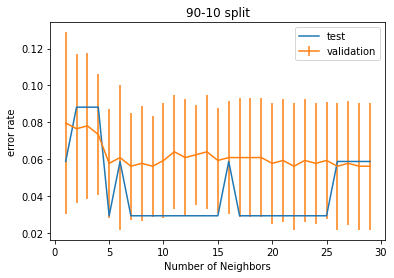

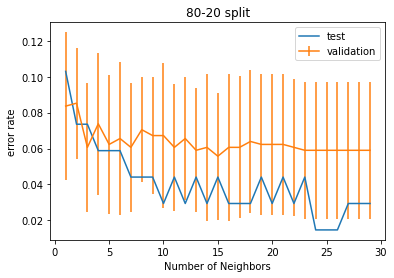

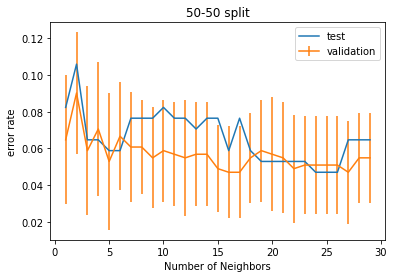

In [21]:
def error_rate(pred, label):
  accuracy = np.sum(pred == label)/label.shape[0]
  return 1-accuracy

def cross_validate(n, n_folds=10):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds


num_folds = 10
(num_instances, num_features), num_classes = x.shape, np.max(y)+1

n_test = num_instances// 20
n_valid = num_instances// 20
  # means train:valid:test = 18:1:1 (train using 90%)
inds = np.random.permutation(num_instances)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
n_rest = num_instances - n_test

#Plot the mean square error for different K values stored in K_list
k_list = range(1,30)
err_test, err_valid = np.zeros(len(k_list)), np.zeros((len(k_list), num_folds))
for i, k in enumerate(k_list):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        NN = KNN(K=k)
        NN = NN.fit(x_rest[tr], y_rest[tr])
        y_prob, knns = NN.predict(x_rest[val])
        y_pred = np.argmax(y_prob, axis=-1)
        err_valid[i, f] = error_rate(y_rest[val], y_pred)
    #this is the part that we don't do in a usual setup. We don't touch the test set until the very end. 
    NN = KNN(K=k)
    NN = NN.fit(x_rest, y_rest)
    y_prob, knns = NN.predict(x_test)
    y_pred = np.argmax(y_prob, axis=-1)
    err_test[i]= error_rate(y_test, y_pred)

plt.plot(k_list, err_test,  label='test')
plt.errorbar(k_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('error rate')
plt.title('90-10 split')
plt.show()

n_test = num_instances// 10
n_valid = num_instances// 10
  # means train:valid:test = 8:1:1 (train using 80%)

inds = np.random.permutation(num_instances)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
n_rest = num_instances - n_test

#Plot the mean square error for different K values stored in K_list
k_list = range(1,30)
err_test, err_valid = np.zeros(len(k_list)), np.zeros((len(k_list), num_folds))
for i, k in enumerate(k_list):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        NN = KNN(K=k)
        NN = NN.fit(x_rest[tr], y_rest[tr])
        y_prob, knns = NN.predict(x_rest[val])
        y_pred = np.argmax(y_prob, axis=-1)
        err_valid[i, f] = error_rate(y_rest[val], y_pred)
    #this is the part that we don't do in a usual setup. We don't touch the test set until the very end. 
    NN = KNN(K=k)
    NN = NN.fit(x_rest, y_rest)
    y_prob, knns = NN.predict(x_test)
    y_pred = np.argmax(y_prob, axis=-1)
    err_test[i]= error_rate(y_test, y_pred)

plt.plot(k_list, err_test,  label='test')
plt.errorbar(k_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('error rate')
plt.title('80-20 split')
plt.show()

n_test = num_instances// 4
n_valid = num_instances// 4
  # means train:valid:test = 2:1:1 (train using 50%)

inds = np.random.permutation(num_instances)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
n_rest = num_instances - n_test

#Plot the mean square error for different K values stored in K_list
k_list = range(1,30)
err_test, err_valid = np.zeros(len(k_list)), np.zeros((len(k_list), num_folds))
for i, k in enumerate(k_list):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        NN = KNN(K=k)
        NN = NN.fit(x_rest[tr], y_rest[tr])
        y_prob, knns = NN.predict(x_rest[val])
        y_pred = np.argmax(y_prob, axis=-1)
        err_valid[i, f] = error_rate(y_rest[val], y_pred)
    #this is the part that we don't do in a usual setup. We don't touch the test set until the very end. 
    NN = KNN(K=k)
    NN = NN.fit(x_rest, y_rest)
    y_prob, knns = NN.predict(x_test)
    y_pred = np.argmax(y_prob, axis=-1)
    err_test[i]= error_rate(y_test, y_pred)

plt.plot(k_list, err_test,  label='test')
plt.errorbar(k_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('error rate')
plt.title('50-50 split')
plt.show()


###Decision Tree

####Accuracy


In [22]:
x = df1_np[:,:-1]
y = df1_np[:,-1]

(num_instances, num_features), num_classes = x.shape, len(np.unique(y, axis=0))
inds = np.random.permutation(num_instances)

#train-test split 50-50 split
x_train, y_train = x[inds[:342]], y[inds[:342]]
x_test, y_test = x[inds[342:]], y[inds[342:]]


tree = DecisionTree(max_depth=20)
probs_test = tree.fit(x_train, y_train).predict(x_test)
y_pred = np.argmax(probs_test,1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')

accuracy is 93.0.


####Visualization

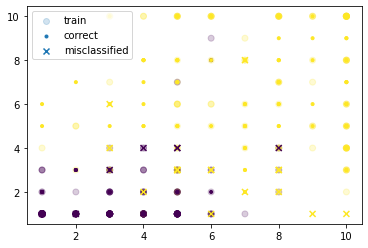

In [23]:
#visualization (plot for 2 features -> most discriminant features)
correct = y_test == y_pred
incorrect = np.logical_not(correct)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')
plt.legend()
plt.show()

#### Decision Boundary

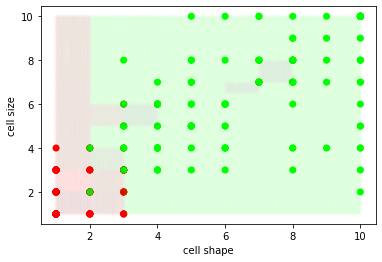

In [24]:
#decision boundary for DT
#uses shape and size as data (because can only visualize 2 dimensions)

x = df1_np[:, 1:3] # TA said to use 2 features for decision boundary plot
y = df1_np[:,-1]
(num_instances, num_features), num_classes = x.shape, len(np.unique(y, axis=0))
inds = np.random.permutation(num_instances)

#train-test split
x_train, y_train = x[inds[:342]], y[inds[:342]]
x_test, y_test = x[inds[342:]], y[inds[342:]]

x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]),200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]),200)
x0, x1 = np.meshgrid(x0v,x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

tree2 = DecisionTree(max_depth=200)
y_train_prob = np.zeros((y_train.shape[0], 3))
  # need to set to 3 because need 3 channels for RGBA
y_train_prob[np.arange(y_train.shape[0]), y_train.astype(int)] = 1
y_prob_all = tree2.fit(x_train, y_train).predict(x_all)
b = np.zeros((y_prob_all.shape[0], 1))
y_prob_all = np.concatenate((y_prob_all, b), axis=1)
  # adds 3rd dimension for RGBA (filled with 0s)

plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=0.01)
plt.ylabel('cell size')
plt.xlabel('cell shape')
plt.show()

####Cross Validation for DT

We are using 5-fold CV, with 80% of the data used for training

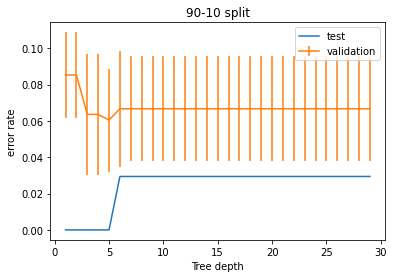

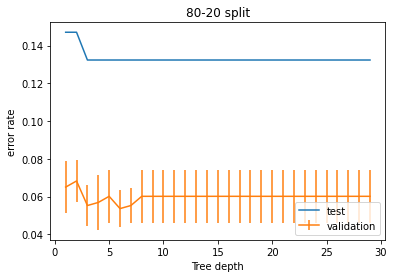

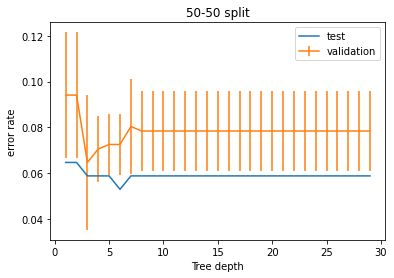

In [25]:
def error_rate(pred, label):
  accuracy = np.sum(pred == label)/label.shape[0]
  return 1-accuracy

def cross_validate(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

num_folds = 10
(num_instances, num_features), num_classes = x.shape, np.max(y)+1

n_test = num_instances// 20
n_valid = num_instances// 20
  # means train:valid:test = 18:1:1 (train using 90%)


inds = np.random.permutation(num_instances)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
n_rest = num_instances - n_test


#Plot the mean square error for different K values stored in K_list
depth_list = range(1,30)
num_folds = 5
err_test, err_valid = np.zeros(len(depth_list)), np.zeros((len(depth_list), num_folds))
for i, depth in enumerate(depth_list):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        tree = DecisionTree(max_depth = depth)
        tree = tree.fit(x_rest[tr], y_rest[tr])
        err_valid[i, f] = error_rate(y_rest[val], np.argmax(tree.predict(x_rest[val]),1))
    #this is the part that we don't do in a usual setup. We don't touch the test set until the very end. 
    tree = DecisionTree(max_depth = depth)
    tree = tree.fit(x_rest, y_rest)
    err_test[i]= error_rate(y_test, np.argmax(tree.predict(x_test),1))
    
plt.plot(depth_list, err_test,  label='test')
plt.errorbar(depth_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Tree depth')
plt.ylabel('error rate')
plt.title('90-10 split')
plt.show()

n_test = num_instances// 10
n_valid = num_instances// 10
  # means train:valid:test = 8:1:1 (train using 80%)

inds = np.random.permutation(num_instances)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
n_rest = num_instances - n_test


#Plot the mean square error for different K values stored in K_list
depth_list = range(1,30)
num_folds = 5
err_test, err_valid = np.zeros(len(depth_list)), np.zeros((len(depth_list), num_folds))
for i, depth in enumerate(depth_list):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        tree = DecisionTree(max_depth = depth)
        tree = tree.fit(x_rest[tr], y_rest[tr])
        err_valid[i, f] = error_rate(y_rest[val], np.argmax(tree.predict(x_rest[val]),1))
    #this is the part that we don't do in a usual setup. We don't touch the test set until the very end. 
    tree = DecisionTree(max_depth = depth)
    tree = tree.fit(x_rest, y_rest)
    err_test[i]= error_rate(y_test, np.argmax(tree.predict(x_test),1))
    
plt.plot(depth_list, err_test,  label='test')
plt.errorbar(depth_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Tree depth')
plt.ylabel('error rate')
plt.title('80-20 split')
plt.show()

n_test = num_instances// 4
n_valid = num_instances// 4
  # means train:valid:test = 2:1:1 (train using 50%)


inds = np.random.permutation(num_instances)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
n_rest = num_instances - n_test


#Plot the mean square error for different K values stored in K_list
depth_list = range(1,30)
num_folds = 5
err_test, err_valid = np.zeros(len(depth_list)), np.zeros((len(depth_list), num_folds))
for i, depth in enumerate(depth_list):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        tree = DecisionTree(max_depth = depth)
        tree = tree.fit(x_rest[tr], y_rest[tr])
        err_valid[i, f] = error_rate(y_rest[val], np.argmax(tree.predict(x_rest[val]),1))
    #this is the part that we don't do in a usual setup. We don't touch the test set until the very end. 
    tree = DecisionTree(max_depth = depth)
    tree = tree.fit(x_rest, y_rest)
    err_test[i]= error_rate(y_test, np.argmax(tree.predict(x_test),1))
    
plt.plot(depth_list, err_test,  label='test')
plt.errorbar(depth_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Tree depth')
plt.ylabel('error rate')
plt.title('50-50 split')
plt.show()

####Best Hyperparameters (Attempt)

In [ ]:
# x = df1_np[:,:-1]
# y = df1_np[:,-1]
# #x, y = df1_np['data'][:,2:4], df1_np['target'][:,10]
# (num_instances, num_features), num_classes = x.shape, np.max(y)+1
# inds = np.random.permutation(num_instances)

# #train-test split)
# #x_train, y_train = x[inds[:342]], y[inds[:342]]
# #x_test, y_test = x[inds[342:]], y[inds[342:]]

# x_train, y_train = x[inds[:544]], y[inds[:544]]
# x_test, y_test = x[inds[544:]], y[inds[544:]]

# plot_training = []
# plot_y = []

# for i in range(1,20):
#     for j in range(18):
#         tree = DecisionTree(max_depth= i,min_leaf_instances=j)
#         probs_test = tree.fit(x_train, y_train).predict(x_test)
#         y_pred = np.argmax(probs_test,1)
#         accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
#         plot_training.append(accuracy)
#         plot_y.append(i)
#         # print(f'accuracy is {accuracy*100:.1f}, i:{i}, j:{j}')

# plt.plot(plot_y,plot_training)
# maximum_accuracy = max(plot_training)
# print("Maximum accuracy = ",maximum_accuracy)

# DATASET 2: Hepatitis



##Task 1: Acquire, preprocess, and analyze the data

###Data Cleaning

Opening file

In [26]:
#unhash the following snippet if you want to work straight from the csv file on google drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
df2 = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Assignment1/hepatitis.csv')

Mounted at /content/gdrive


Remove Rows with Missing Data


In [27]:
print(df2.shape[0], 'initial rows')
df2 = df2.replace('?', np.nan)
df2 = df2.dropna()
df2.reset_index(drop=True, inplace=True) #reset indices (so first instance at index 0, next at index 1...)
df2 = df2.astype(float) # all values are float (instead of string)
print(df2.shape[0], ' rows after remove instances with missing data ')

df2['Class'] = df2['Class'].replace([1.0], 0)
df2['Class'] = df2['Class'].replace([2.0], 1)
  # replace 1 with 0, 2 with 1 (for decision boundary later)

df2

155 initial rows
80  rows after remove instances with missing data 


,Class,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
0,1.0,34.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.9,95.0,28.0,4.0,75.0,1.0
1,1.0,39.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.3,78.0,30.0,4.4,85.0,1.0
2,1.0,32.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,59.0,249.0,3.7,54.0,1.0
3,1.0,41.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0.9,81.0,60.0,3.9,52.0,1.0
4,1.0,30.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.2,57.0,144.0,4.9,78.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1.0,45.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.3,85.0,44.0,4.2,85.0,2.0
76,0.0,49.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.4,85.0,70.0,3.5,35.0,2.0
77,1.0,31.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.2,75.0,173.0,4.2,54.0,2.0
78,1.0,53.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,1.5,81.0,19.0,4.1,48.0,2.0


Removal of outliers

In [28]:
#only removes outliers in continuous features (NOT categorical)
df_cat = df2.loc[:, ['Class', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE', 'ANOREXIA', 'LIVER_BIG', 'LIVER_FIRM', 'SPLEEN_PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES', 'HISTOLOGY']]
df_cont = df2.loc[:, ['AGE', 'BILIRUBIN', 'ALK_PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME']]
idx = np.all(stats.zscore(df_cont) < 3, axis=1)
df2 = pd.concat([df_cat.loc[idx], df_cont.loc[idx]], axis=1)
df2 = df2.dropna()
df2.reset_index(drop=True, inplace=True) #reset indices (so first instance at index 0, next at index 1...)

print(df2.shape[0], ' rows after outlier removal')
df2


75  rows after outlier removal


,Class,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,HISTOLOGY,AGE,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME
0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,34.0,0.9,95.0,28.0,4.0,75.0
1,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,39.0,1.3,78.0,30.0,4.4,85.0
2,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,32.0,1.0,59.0,249.0,3.7,54.0
3,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,41.0,0.9,81.0,60.0,3.9,52.0
4,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,30.0,2.2,57.0,144.0,4.9,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,45.0,1.3,85.0,44.0,4.2,85.0
71,0.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,49.0,1.4,85.0,70.0,3.5,35.0
72,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,31.0,1.2,75.0,173.0,4.2,54.0
73,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,53.0,1.5,81.0,19.0,4.1,48.0


###Statistics

In [ ]:
df2.describe()

,Class,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,HISTOLOGY,AGE,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,0.866667,1.133333,1.546667,1.733333,1.373333,1.653333,1.853333,1.826667,1.546667,1.813333,1.706667,1.866667,1.893333,1.400000,40.400000,1.061333,97.893333,74.173333,3.873333,64.040000
std,0.342224,0.342224,0.501170,0.445195,0.486947,0.479113,0.356156,0.381084,0.501170,0.392268,0.458356,0.342224,0.310768,0.493197,11.304149,0.538490,48.388790,57.490392,0.572650,23.314211
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.000000,0.300000,26.000000,14.000000,2.100000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,32.000000,0.700000,62.500000,30.000000,3.600000,47.500000
50%,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,38.000000,1.000000,85.000000,55.000000,4.000000,64.000000
75%,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,49.000000,1.250000,127.500000,92.000000,4.200000,81.000000
max,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,72.000000,3.500000,243.000000,249.000000,5.000000,100.000000


Number of Occurences

In [ ]:
# 0 = die, 1 = live
die = df2.loc[(df2['Class'] == 0)] 
num_die = die.shape[0]
live = df2.loc[(df2['Class'] == 1)] 
num_live = live.shape[0]

print('Total # Patients: ', num_live+num_die)
print('# Live: ', num_live)
print('# Die: ', num_die)
per_die = (num_die)/(num_live+num_die) * 100
print("% Die: " + str(int(per_die)) + '%')

Total # Patients:  75
# Live:  65
# Die:  10
% Die: 13%


####Distribution by Feature

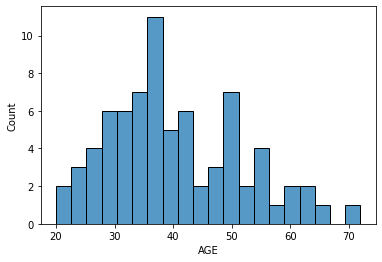

In [ ]:
sns.histplot(df2['AGE'], bins = 20, kde = False)

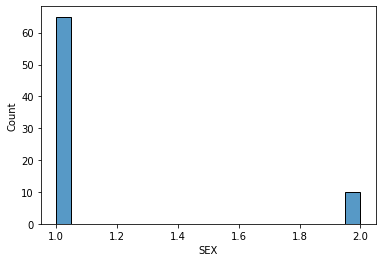

In [ ]:
sns.histplot(df2['SEX'], bins = 20, kde = False)

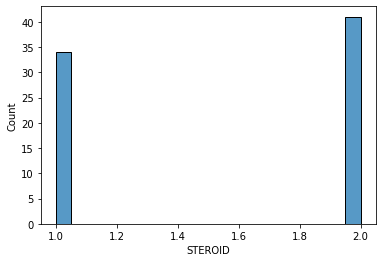

In [ ]:
sns.histplot(df2['STEROID'], bins = 20, kde = False)

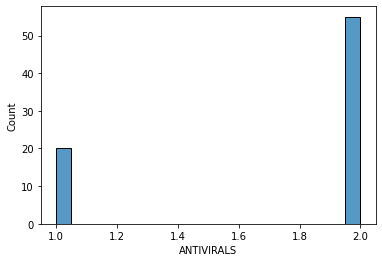

In [ ]:
sns.histplot(df2['ANTIVIRALS'], bins = 20, kde = False)

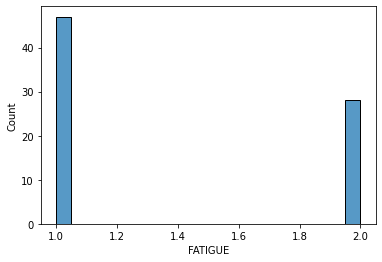

In [ ]:
sns.histplot(df2['FATIGUE'], bins = 20, kde = False)

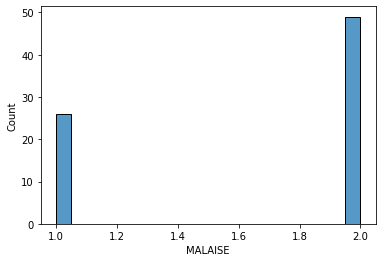

In [ ]:
sns.histplot(df2['MALAISE'], bins = 20, kde = False)

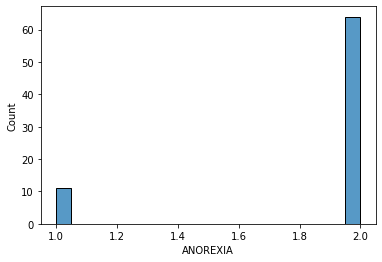

In [ ]:
sns.histplot(df2['ANOREXIA'], bins = 20, kde = False)

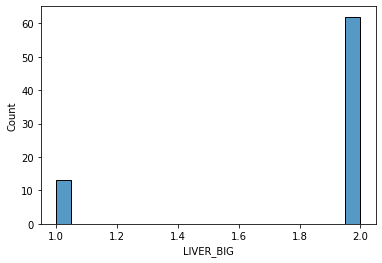

In [ ]:
sns.histplot(df2['LIVER_BIG'], bins = 20, kde = False)

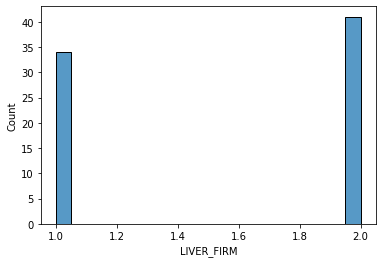

In [ ]:
sns.histplot(df2['LIVER_FIRM'], bins = 20, kde = False)

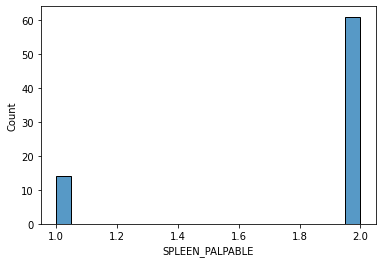

In [ ]:
sns.histplot(df2['SPLEEN_PALPABLE'], bins = 20, kde = False)

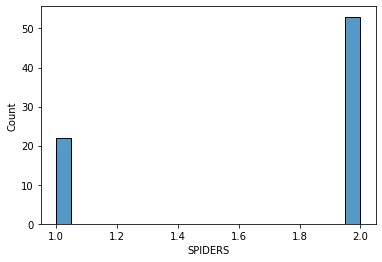

In [ ]:
sns.histplot(df2['SPIDERS'], bins = 20, kde = False)

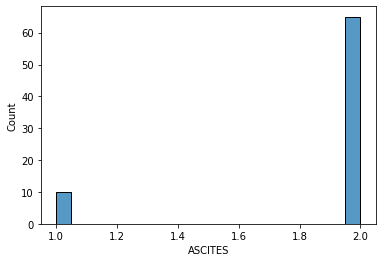

In [ ]:
sns.histplot(df2['ASCITES'], bins = 20, kde = False)

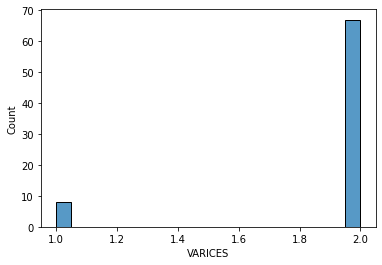

In [ ]:
sns.histplot(df2['VARICES'], bins = 20, kde = False)

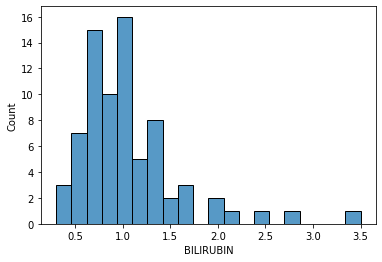

In [ ]:
sns.histplot(df2['BILIRUBIN'], bins = 20, kde = False)

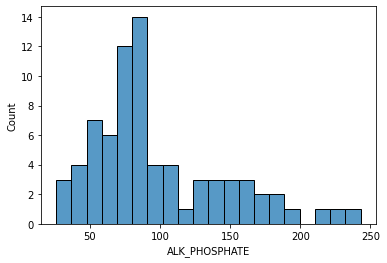

In [ ]:
sns.histplot(df2['ALK_PHOSPHATE'], bins = 20, kde = False)

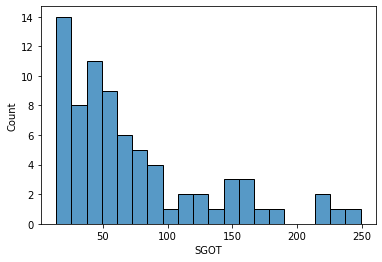

In [ ]:
sns.histplot(df2['SGOT'], bins = 20, kde = False)

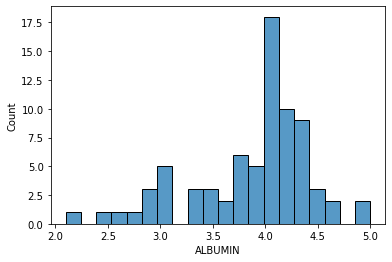

In [ ]:
sns.histplot(df2['ALBUMIN'], bins = 20, kde = False)

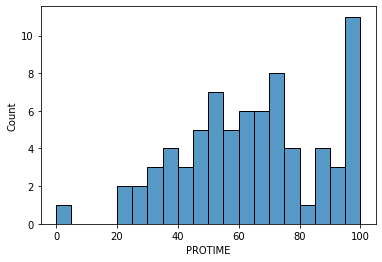

In [ ]:
sns.histplot(df2['PROTIME'], bins = 20, kde = False)

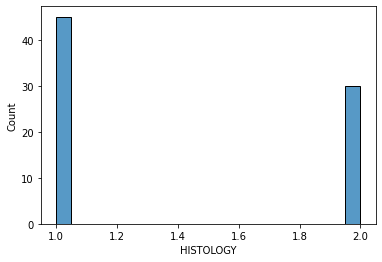

In [ ]:
sns.histplot(df2['HISTOLOGY'], bins = 20, kde = False)

####Positive vs. Negative Distribution by Feature

In [ ]:
pos = df2[df2['Class'] == 1]
neg = df2[df2['Class'] == 0]

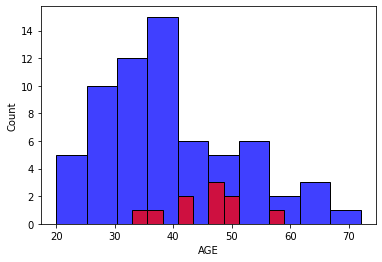

In [ ]:
sns.histplot(pos['AGE'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['AGE'], bins = 10, color = 'r', kde = False)

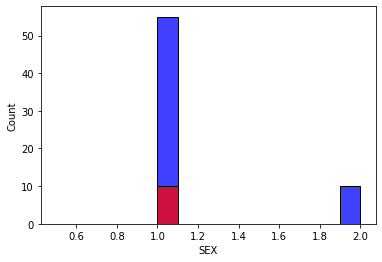

In [ ]:
sns.histplot(pos['SEX'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['SEX'], bins = 10, color = 'r', kde = False)

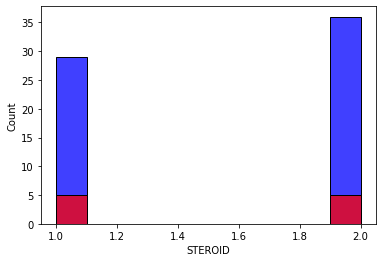

In [ ]:
sns.histplot(pos['STEROID'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['STEROID'], bins = 10, color = 'r', kde = False)

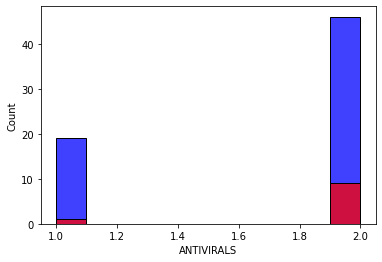

In [ ]:
sns.histplot(pos['ANTIVIRALS'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['ANTIVIRALS'], bins = 10, color = 'r', kde = False)

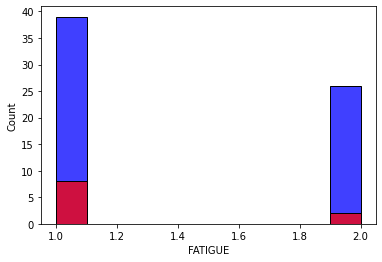

In [ ]:
sns.histplot(pos['FATIGUE'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['FATIGUE'], bins = 10, color = 'r', kde = False)

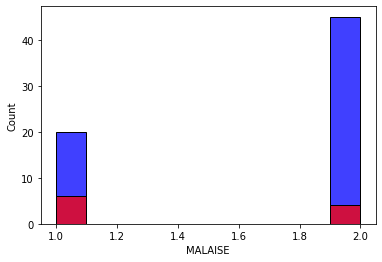

In [ ]:
sns.histplot(pos['MALAISE'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['MALAISE'], bins = 10, color = 'r', kde = False)

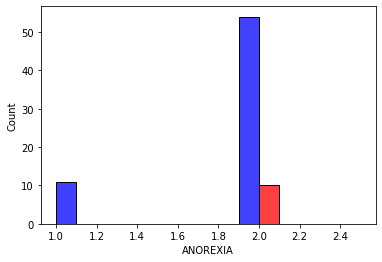

In [ ]:
sns.histplot(pos['ANOREXIA'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['ANOREXIA'], bins = 10, color = 'r', kde = False)

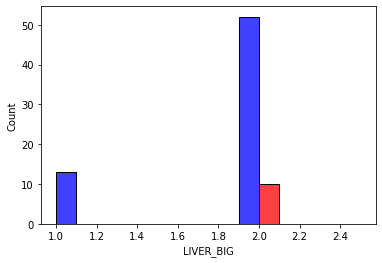

In [ ]:
sns.histplot(pos['LIVER_BIG'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['LIVER_BIG'], bins = 10, color = 'r', kde = False)

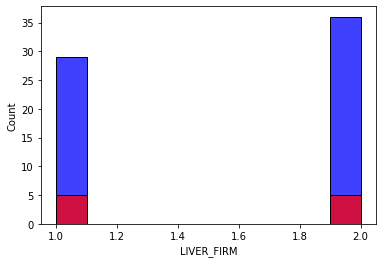

In [ ]:
sns.histplot(pos['LIVER_FIRM'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['LIVER_FIRM'], bins = 10, color = 'r', kde = False)

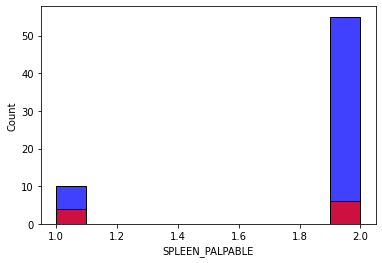

In [ ]:
sns.histplot(pos['SPLEEN_PALPABLE'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['SPLEEN_PALPABLE'], bins = 10, color = 'r', kde = False)

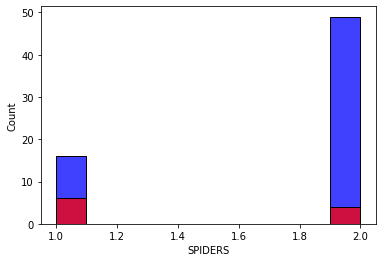

In [ ]:
sns.histplot(pos['SPIDERS'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['SPIDERS'], bins = 10, color = 'r', kde = False)

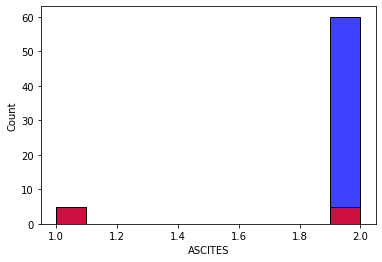

In [ ]:
sns.histplot(pos['ASCITES'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['ASCITES'], bins = 10, color = 'r', kde = False)

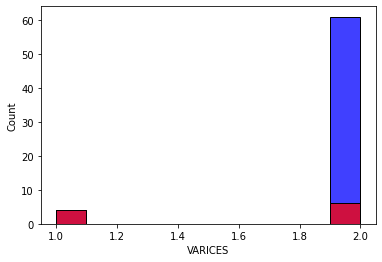

In [ ]:
sns.histplot(pos['VARICES'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['VARICES'], bins = 10, color = 'r', kde = False)

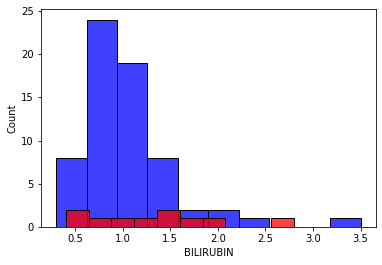

In [ ]:
sns.histplot(pos['BILIRUBIN'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['BILIRUBIN'], bins = 10, color = 'r', kde = False)

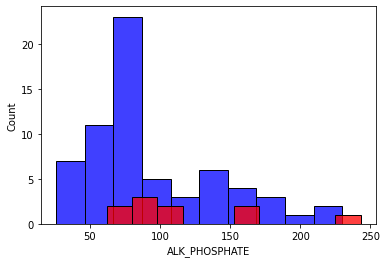

In [ ]:
sns.histplot(pos['ALK_PHOSPHATE'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['ALK_PHOSPHATE'], bins = 10, color = 'r', kde = False)

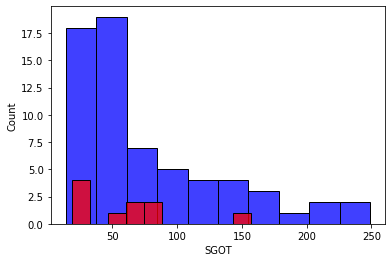

In [ ]:
sns.histplot(pos['SGOT'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['SGOT'], bins = 10, color = 'r', kde = False)

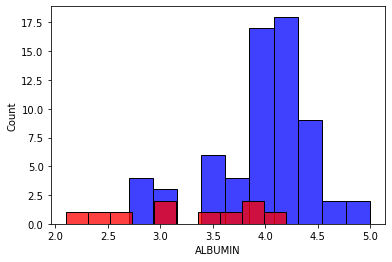

In [ ]:
sns.histplot(pos['ALBUMIN'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['ALBUMIN'], bins = 10, color = 'r', kde = False)

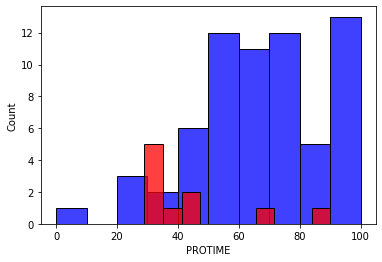

In [ ]:
sns.histplot(pos['PROTIME'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['PROTIME'], bins = 10, color = 'r', kde = False)

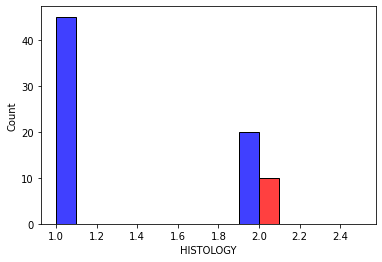

In [ ]:
sns.histplot(pos['HISTOLOGY'], bins = 10, color = 'b', kde = False)
sns.histplot(neg['HISTOLOGY'], bins = 10, color = 'r', kde = False)

###Correlation

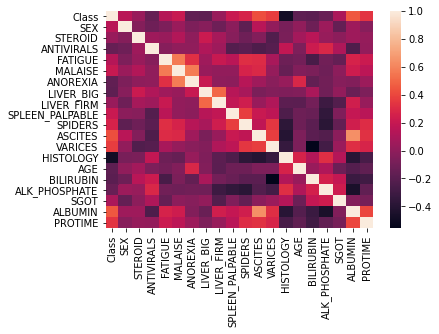

In [ ]:
corr_matrix = df2.corr()
plt.clf()
sns.heatmap(corr_matrix) #annot=True)
plt.show()

##Task 2 & 3: Implement the Models and Run Experiments

###Convert to Numpy Array for ML

In [29]:
df2_np = df2.to_numpy() 

###KNN

####Accuracy with 50-50 split

In [30]:
x = df2_np[:,1:] # TA said to train on all features initially for part 2 
y = df2_np[:,0]


(N, D), C = x.shape, np.max(y)+1
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

inds = np.random.permutation(N)

x_train, y_train = x[inds[:40]], y[inds[:40]]
x_test, y_test = x[inds[40:]], y[inds[40:]]

model = KNN(K=3)

y_prob, knns = model.fit(x_train, y_train).predict(x_test)
print('knns shape:', knns.shape)
print('y_prob shape:', y_prob.shape)

#To get hard predictions by choosing the class with the maximum probability
y_pred = np.argmax(y_prob,axis=-1)

accuracy = np.sum(y_pred == y_test)/y_test.shape[0]

print(f'accuracy is {accuracy*100:.1f}.')


instances (N) 	 75 
 features (D) 	 19 
 classes (C) 	 2.0
knns shape: (35, 3)
y_prob shape: (35, 2)
accuracy is 88.6.


#### Visualization

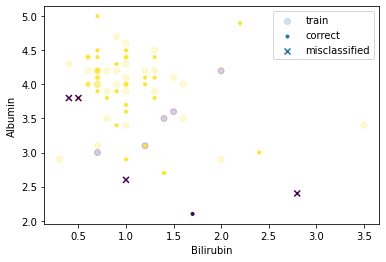

In [31]:
#visualization (plot for 2 features -> most discriminant features)
correct = y_test == y_pred
incorrect = np.logical_not(correct)
plt.scatter(x_train[:,-5], x_train[:,-2], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,-5], x_test[correct,-2], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,-5], x_test[incorrect,-2], marker='x', c=y_test[incorrect], label='misclassified')
plt.legend()
plt.ylabel('Albumin')
plt.xlabel('Bilirubin')
plt.show()


####Decision Boundary

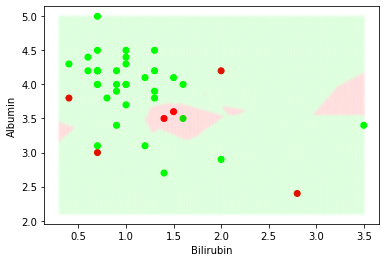

In [32]:
#decision boundary for KNN
#uses shape and size as data (because can only visualize 2 dimensions)

x = df2_np[:, [15,18]]
y = df2_np[:,0]
(num_instances, num_features), num_classes = x.shape, len(np.unique(y, axis=0))
inds = np.random.permutation(num_instances)

#train-test split
x_train, y_train = x[inds[:40]], y[inds[:40]]
x_test, y_test = x[inds[40:]], y[inds[40:]]

x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]),200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]),200)
x0, x1 = np.meshgrid(x0v,x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model2H = KNN(K=3)
y_train_prob = np.zeros((y_train.shape[0], 3))
  # need to set to 3 because need 3 channels for RGBA
y_train_prob[np.arange(y_train.shape[0]), y_train.astype(int)] = 1
y_prob_all, _ = model2H.fit(x_train, y_train).predict(x_all)
b = np.zeros((y_prob_all.shape[0], 1))
y_prob_all = np.concatenate((y_prob_all, b), axis=1)
  # adds 3rd dimension for RGBA (filled with 0s)

y_pred_all = np.zeros_like(y_prob_all)
y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
plt.ylabel('Albumin')
plt.xlabel('Bilirubin')
plt.show()

####Cross Validation for KNN

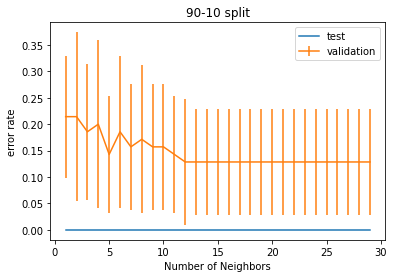

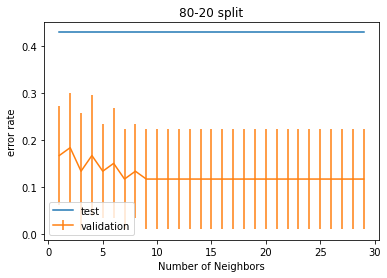

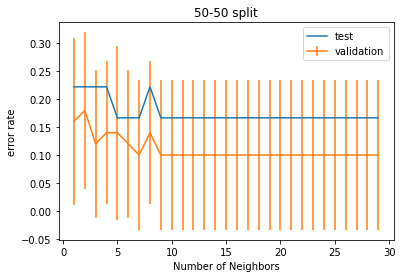

In [33]:
def error_rate(pred, label):
  accuracy = np.sum(pred == label)/label.shape[0]
  return 1-accuracy

def cross_validate(n, n_folds=10):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds


num_folds = 10
(num_instances, num_features), num_classes = x.shape, np.max(y)+1

n_test = num_instances// 20
n_valid = num_instances// 20
  # means train:valid:test = 18:1:1 (train using 90%)

inds = np.random.permutation(num_instances)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
n_rest = num_instances - n_test

#Plot the mean square error for different K values stored in K_list
k_list = range(1,30)
err_test, err_valid = np.zeros(len(k_list)), np.zeros((len(k_list), num_folds))
for i, k in enumerate(k_list):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        NN = KNN(K=k)
        NN = NN.fit(x_rest[tr], y_rest[tr])
        y_prob, knns = NN.predict(x_rest[val])
        y_pred = np.argmax(y_prob, axis=-1)
        err_valid[i, f] = error_rate(y_rest[val], y_pred)
    #this is the part that we don't do in a usual setup. We don't touch the test set until the very end. 
    NN = KNN(K=k)
    NN = NN.fit(x_rest, y_rest)
    y_prob, knns = NN.predict(x_test)
    y_pred = np.argmax(y_prob, axis=-1)
    err_test[i]= error_rate(y_test, y_pred)

plt.plot(k_list, err_test,  label='test')
plt.errorbar(k_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('error rate')
plt.title('90-10 split')
plt.show()

n_test = num_instances// 10
n_valid = num_instances// 10
  # means train:valid:test = 8:1:1 (train using 80%)

inds = np.random.permutation(num_instances)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
n_rest = num_instances - n_test

#Plot the mean square error for different K values stored in K_list
k_list = range(1,30)
err_test, err_valid = np.zeros(len(k_list)), np.zeros((len(k_list), num_folds))
for i, k in enumerate(k_list):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        NN = KNN(K=k)
        NN = NN.fit(x_rest[tr], y_rest[tr])
        y_prob, knns = NN.predict(x_rest[val])
        y_pred = np.argmax(y_prob, axis=-1)
        err_valid[i, f] = error_rate(y_rest[val], y_pred)
    #this is the part that we don't do in a usual setup. We don't touch the test set until the very end. 
    NN = KNN(K=k)
    NN = NN.fit(x_rest, y_rest)
    y_prob, knns = NN.predict(x_test)
    y_pred = np.argmax(y_prob, axis=-1)
    err_test[i]= error_rate(y_test, y_pred)

plt.plot(k_list, err_test,  label='test')
plt.errorbar(k_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('error rate')
plt.title('80-20 split')
plt.show()

n_test = num_instances// 4
n_valid = num_instances// 4
  # means train:valid:test = 2:1:1 (train using 50%)

inds = np.random.permutation(num_instances)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
n_rest = num_instances - n_test

#Plot the mean square error for different K values stored in K_list
k_list = range(1,30)
err_test, err_valid = np.zeros(len(k_list)), np.zeros((len(k_list), num_folds))
for i, k in enumerate(k_list):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        NN = KNN(K=k)
        NN = NN.fit(x_rest[tr], y_rest[tr])
        y_prob, knns = NN.predict(x_rest[val])
        y_pred = np.argmax(y_prob, axis=-1)
        err_valid[i, f] = error_rate(y_rest[val], y_pred)
    #this is the part that we don't do in a usual setup. We don't touch the test set until the very end. 
    NN = KNN(K=k)
    NN = NN.fit(x_rest, y_rest)
    y_prob, knns = NN.predict(x_test)
    y_pred = np.argmax(y_prob, axis=-1)
    err_test[i]= error_rate(y_test, y_pred)

plt.plot(k_list, err_test,  label='test')
plt.errorbar(k_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('error rate')
plt.title('50-50 split')
plt.show()


###Decision Tree

####Accuracy with 50-50 split

In [34]:
x = df2_np[:,1:] # TA said to train on all features initially for part 2 
y = df2_np[:,0]

(N, D), C = x.shape, np.max(y)+1
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

inds = np.random.permutation(N)

x_train, y_train = x[inds[:40]], y[inds[:40]]
x_test, y_test = x[inds[40:]], y[inds[40:]]

tree = DecisionTree(max_depth=20)
tree = tree.fit(x_train, y_train)
probs_test = tree.predict(x_test)
y_pred = np.argmax(probs_test,1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')


instances (N) 	 75 
 features (D) 	 19 
 classes (C) 	 2.0
accuracy is 80.0.


####Visualization

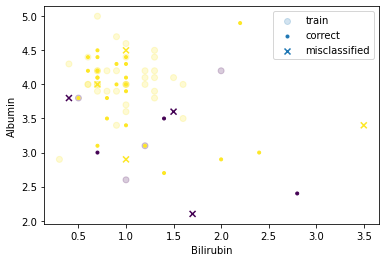

In [35]:
#visualization (plot for 2 features -> most discriminant features)
correct = y_test == y_pred
incorrect = np.logical_not(correct)
plt.scatter(x_train[:,-5], x_train[:,-2], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,-5], x_test[correct,-2], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,-5], x_test[incorrect,-2], marker='x', c=y_test[incorrect], label='misclassified')
plt.legend()
plt.ylabel('Albumin')
plt.xlabel('Bilirubin')
plt.show()

####Decision Boundary

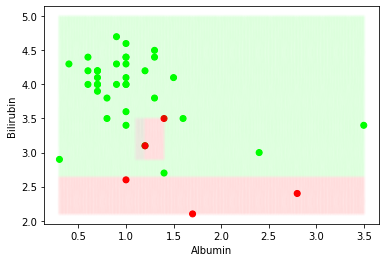

In [36]:
#decision boundary for DT
x = df2_np[:, [15,18]]
y = df2_np[:,0]

(num_instances, num_features), num_classes = x.shape, len(np.unique(y, axis=0))
inds = np.random.permutation(num_instances)

x_train, y_train = x[inds[:40]], y[inds[:40]]
x_test, y_test = x[inds[40:]], y[inds[40:]]

x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]),200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]),200)
x0, x1 = np.meshgrid(x0v,x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

tree2 = DecisionTree(max_depth=20)
y_train_prob = np.zeros((y_train.shape[0], 3))
  # need to set to 3 because need 3 channels for RGBA
y_train_prob[np.arange(y_train.shape[0]), y_train.astype(int)] = 1
y_prob_all = tree2.fit(x_train, y_train).predict(x_all)
b = np.zeros((y_prob_all.shape[0], 1))
y_prob_all = np.concatenate((y_prob_all, b), axis=1)
  # adds 3rd dimension for RGBA (filled with 0s)

plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=0.01)
plt.ylabel('Bilirubin')
plt.xlabel('Albumin')
plt.show()



####Cross Validation for DT


We are using 5-fold CV with 2:1:1 train:validation:test (50

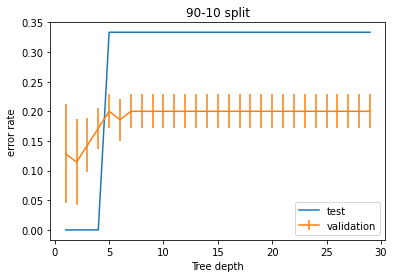

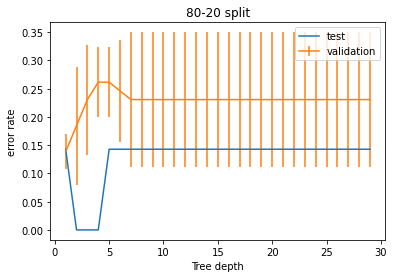

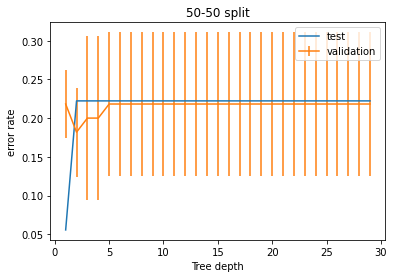

In [37]:
def error_rate(pred, label):
  accuracy = np.sum(pred == label)/label.shape[0]
  return 1-accuracy

def cross_validate(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

num_folds = 10
(num_instances, num_features), num_classes = x.shape, np.max(y)+1

n_test = num_instances// 20
n_valid = num_instances// 20
  # means train:valid:test = 18:1:1 (train using 90%)

inds = np.random.permutation(num_instances)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
n_rest = num_instances - n_test


#Plot the mean square error for different K values stored in K_list
depth_list = range(1,30)
num_folds = 5
err_test, err_valid = np.zeros(len(depth_list)), np.zeros((len(depth_list), num_folds))
for i, depth in enumerate(depth_list):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        tree = DecisionTree(max_depth = depth)
        tree = tree.fit(x_rest[tr], y_rest[tr])
        err_valid[i, f] = error_rate(y_rest[val], np.argmax(tree.predict(x_rest[val]),1))
    #this is the part that we don't do in a usual setup. We don't touch the test set until the very end. 
    tree = DecisionTree(max_depth = depth)
    tree = tree.fit(x_rest, y_rest)
    err_test[i]= error_rate(y_test, np.argmax(tree.predict(x_test),1))
    
plt.plot(depth_list, err_test,  label='test')
plt.errorbar(depth_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Tree depth')
plt.ylabel('error rate')
plt.title('90-10 split')
plt.show()

n_test = num_instances// 10
n_valid = num_instances// 10
  # means train:valid:test = 8:1:1 (train using 80%)

inds = np.random.permutation(num_instances)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
n_rest = num_instances - n_test


#Plot the mean square error for different K values stored in K_list
depth_list = range(1,30)
num_folds = 5
err_test, err_valid = np.zeros(len(depth_list)), np.zeros((len(depth_list), num_folds))
for i, depth in enumerate(depth_list):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        tree = DecisionTree(max_depth = depth)
        tree = tree.fit(x_rest[tr], y_rest[tr])
        err_valid[i, f] = error_rate(y_rest[val], np.argmax(tree.predict(x_rest[val]),1))
    #this is the part that we don't do in a usual setup. We don't touch the test set until the very end. 
    tree = DecisionTree(max_depth = depth)
    tree = tree.fit(x_rest, y_rest)
    err_test[i]= error_rate(y_test, np.argmax(tree.predict(x_test),1))
    
plt.plot(depth_list, err_test,  label='test')
plt.errorbar(depth_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Tree depth')
plt.ylabel('error rate')
plt.title('80-20 split')
plt.show()

n_test = num_instances// 4
n_valid = num_instances// 4
  # means train:valid:test = 2:1:1 (train using 50%)


inds = np.random.permutation(num_instances)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
n_rest = num_instances - n_test


#Plot the mean square error for different K values stored in K_list
depth_list = range(1,30)
num_folds = 5
err_test, err_valid = np.zeros(len(depth_list)), np.zeros((len(depth_list), num_folds))
for i, depth in enumerate(depth_list):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        tree = DecisionTree(max_depth = depth)
        tree = tree.fit(x_rest[tr], y_rest[tr])
        err_valid[i, f] = error_rate(y_rest[val], np.argmax(tree.predict(x_rest[val]),1))
    #this is the part that we don't do in a usual setup. We don't touch the test set until the very end. 
    tree = DecisionTree(max_depth = depth)
    tree = tree.fit(x_rest, y_rest)
    err_test[i]= error_rate(y_test, np.argmax(tree.predict(x_test),1))
    
plt.plot(depth_list, err_test,  label='test')
plt.errorbar(depth_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Tree depth')
plt.ylabel('error rate')
plt.title('50-50 split')
plt.show()